In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [1]:
import numpy as np
import tensorflow as tf
import re
import pandas as pd
import spacy
import gc
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, vstack as sparse_vstack
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input, layers
from tensorflow.keras.layers import Embedding, Dot, Reshape, Dense,Bidirectional, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams, pad_sequences
from keras.callbacks import TensorBoard

# **FASE 1**

In [2]:
# Step 1: Load data
train_df = pd.read_csv('train.csv', encoding='latin1')
test_df = pd.read_csv('test.csv', encoding='latin1')

def limpiar_texto(texto):
    texto = re.sub(r'[^\w\s]', '', str(texto)).lower()
    return texto

Por ejemplo, las 3 primeras entradas de `train_df`:

In [3]:
train_df.head(3)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18


Recuento de NaNs:

In [4]:
# Contar NaNs por columna en train_df
print("NaNs en train_df:")
print(train_df.isna().sum())

# Contar NaNs por columna en test_df
print("\nNaNs en test_df:")
print(test_df.isna().sum())

NaNs en train_df:
textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

NaNs en test_df:
textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64


In [5]:
# Eliminar filas con NaN en la columna 'text' en test_df
test_df = test_df.dropna(subset=['text'])
train_df = train_df.dropna(subset=['text'])

In [6]:
# 1) Carga y limpieza
train_df['text_clean'] = train_df['text'].apply(limpiar_texto)
test_df ['text_clean'] = test_df ['text'].apply(limpiar_texto)


train_corpus = train_df['text_clean'].tolist()
test_corpus  = test_df ['text_clean'].tolist()
corpus       = train_corpus + test_corpus

print(f"Frases usadas → train: {len(train_corpus)}, test: {len(test_corpus)}")

# 3) Tokenizer limitado a 3000 palabras + OOV
tokenizer = Tokenizer(num_words=3000, oov_token='<OOV>')
tokenizer.fit_on_texts(corpus)
vocab_size = 3000 + 1

# Diccionarios para después
word2idx = tokenizer.word_index
idx2word = {i:w for w,i in word2idx.items()}

# 4) Top-10 nombres con spaCy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

stop_words = set(nlp.Defaults.stop_words) | {'nan'}


Frases usadas → train: 27480, test: 3534


Distribución de cantidad de palabras por frase:

<Axes: >

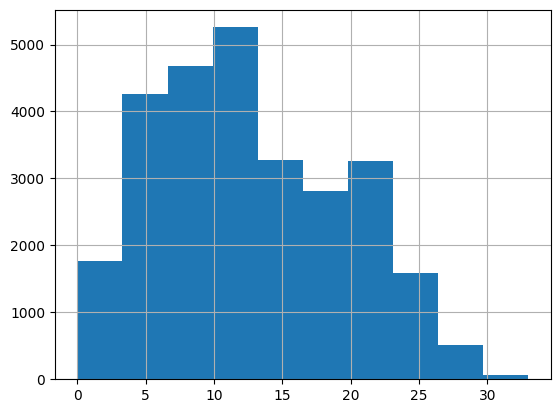

In [24]:
train_df['text_clean'].str.split().map(len).hist()

Número de palabras únicas (vocabulario) que el tokenizer ha aprendido al ajustarse al texto:

In [25]:
len(tokenizer.word_index)

31452

# **FASE 2**

In [9]:
# Lista de palabras a analizar
palabras = [w for w in tokenizer.word_counts if len(w) >= 2 and w not in stop_words]

# Procesamos todas las palabras de una vez (más eficiente)
docs = list(nlp.pipe(palabras, batch_size=1000))

# Filtramos por NOUN o PROPN
filtradas = {
    w: tokenizer.word_counts[w]
    for w, doc in zip(palabras, docs)
    if any(token.pos_ in {"NOUN", "PROPN"} for token in doc)
}

# Top 10
top_10 = sorted(filtradas.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nombres con significado:")
for i, (w, f) in enumerate(top_10, 1):
    print(f"{i}. {w:<15} → {f} apariciones")


Top 10 nombres con significado:
1. day             → 2269 apariciones
2. love            → 1281 apariciones
3. today           → 1218 apariciones
4. lol             → 1062 apariciones
5. time            → 1056 apariciones
6. night           → 834 apariciones
7. home            → 800 apariciones
8. mothers         → 798 apariciones
9. thanks          → 745 apariciones
10. hope            → 660 apariciones


In [10]:
# 5) Secuencias
train_sequences = tokenizer.texts_to_sequences(train_corpus)
test_sequences  = tokenizer.texts_to_sequences(test_corpus)
all_sequences        = train_sequences + test_sequences

In [11]:
from tensorflow.keras.preprocessing.sequence import skipgrams

# Paso 3: Generación de pares con ventanas 2 y 4
pairs_dict = {
    'window_2': [],
    'window_4': []
}

for seq in all_sequences:
    # Ventana 2
    sg_pairs_2, labels_2 = skipgrams(seq, vocab_size, window_size=2, negative_samples=0)
    # Generar pares con etiquetas y añadir a pairs_dict
    pairs_dict['window_2'].extend(zip(sg_pairs_2, labels_2))

    # Ventana 4
    sg_pairs_4, labels_4 = skipgrams(seq, vocab_size, window_size=4, negative_samples=0)
    # Generar pares con etiquetas y añadir a pairs_dict
    pairs_dict['window_4'].extend(zip(sg_pairs_4, labels_4))


In [12]:
from tensorflow.keras.optimizers import Adam
# Hiperparámetros y estructuras
embedding_sizes  = [45,312,752]
window_sizes     = ['window_2','window_4']
loss_histories   = {}
final_embeddings = {}
models           = {}

for emb_size in embedding_sizes:
    for window in window_sizes:
        current_pairs = pairs_dict[window]
        if not current_pairs:
            continue

        # Separar pares y etiquetas
        pairs, labels = zip(*current_pairs)

        # Separar targets y contexts de los pares
        targets, contexts = zip(*pairs)

        # Convertir a arrays
        targets  = np.array(targets, dtype='int32')
        contexts = np.array(contexts, dtype='int32')
        y_train  = np.array(labels, dtype='float32')

        # ENTRADAS como índices, no one-hot
        target_input = Input(shape=(), dtype='int32', name='target_input')
        context_input= Input(shape=(), dtype='int32', name='context_input')

        # Capa de embeddings compartida
        embedding_layer = Embedding(
            input_dim=vocab_size,
            output_dim=emb_size,
            name=f"embedding_{emb_size}_{window}"
        )

        # Vectores de palabras
        target_vector  = embedding_layer(target_input)
        context_vector = embedding_layer(context_input)

        # Producto punto
        dot_product = Dot(axes=-1)([target_vector, context_vector])
        dot_product = Reshape((1,))(dot_product)

        # Clasificador binario
        output = Dense(1, activation='sigmoid')(dot_product)



        # Construir modelo
        model = Model(inputs=[target_input, context_input], outputs=output)
        model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(0.02),
            metrics=['accuracy']
        )

        # Guardar y entrenar
        key = f'emb_{emb_size}_{window}'
        print(f"\nEntrenando modelo: {key} (Embedding size: {emb_size}, Window: {window})\n")
        models[key] = model
        history = model.fit(
            [targets, contexts],
            y_train,
            epochs=3,
            batch_size=256,
            verbose=1
        )

        loss_histories[key]   = history.history['loss']
        final_embeddings[key] = embedding_layer.get_weights()[0]


Entrenando modelo: emb_45_window_2 (Embedding size: 45, Window: window_2)

Epoch 1/3
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9988 - loss: 0.0142
Epoch 2/3
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 1.0000 - loss: 3.0582e-07
Epoch 3/3
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 1.9480e-08

Entrenando modelo: emb_45_window_4 (Embedding size: 45, Window: window_4)

Epoch 1/3
9895/9895 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9992 - loss: 0.0343
Epoch 2/3
9895/9895 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 1.0000 - loss: 8.7892e-06
Epoch 3/3
9895/9895 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 1.0000 - loss: 6.3672e-08

Entrenando modelo: emb_312_window_2 (Embedding size: 312, Window: window_2)

Epoch 1/3
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9977 - loss: 0.0534
Epoch 2/3
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 1.1313e-04
Epoch 3/3
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 21s 2

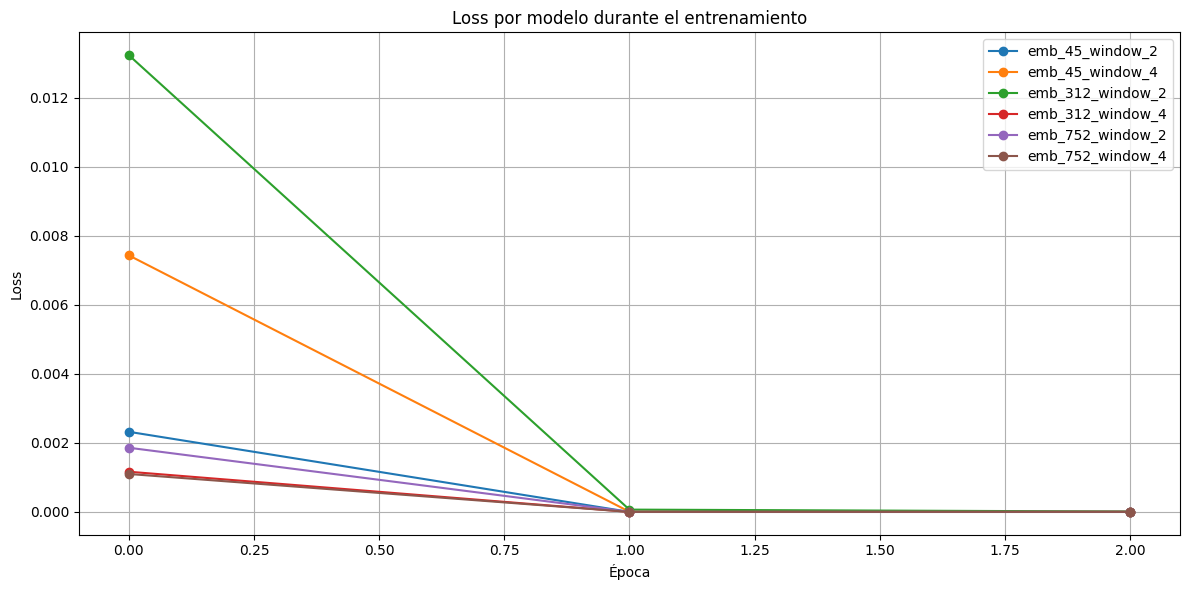

In [13]:
plt.figure(figsize=(12, 6))

for key, loss in loss_histories.items():
    plt.plot(loss, marker='o',label=key)

plt.title('Loss por modelo durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Recorre cada modelo en el diccionario y muestra su summary
for key, mdl in models.items():
    print(f"\n=== Summary de {key} ===")
    mdl.summary()



=== Summary de emb_45_window_2 ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_45_windo… │ (None, 45)        │    135,045 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ embedding_45_win… │
│                     │                   │            │ embedding_45_win… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1)         │          0 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ reshape[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 405,143 (1.55 MB)

 Trainable params: 135,047 (527.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 270,096 (1.03 MB)


=== Summary de emb_45_window_4 ===


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_45_windo… │ (None, 45)        │    135,045 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1)         │          0 │ embedding_45_win… │
│                     │                   │            │ embedding_45_win… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1)         │          0 │ dot_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ reshape_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 405,143 (1.55 MB)

 Trainable params: 135,047 (527.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 270,096 (1.03 MB)


=== Summary de emb_312_window_2 ===


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_312_wind… │ (None, 312)       │    936,312 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_2 (Dot)         │ (None, 1)         │          0 │ embedding_312_wi… │
│                     │                   │            │ embedding_312_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1)         │          0 │ dot_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ reshape_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,808,944 (10.72 MB)

 Trainable params: 936,314 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,872,630 (7.14 MB)


=== Summary de emb_312_window_4 ===


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_312_wind… │ (None, 312)       │    936,312 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_3 (Dot)         │ (None, 1)         │          0 │ embedding_312_wi… │
│                     │                   │            │ embedding_312_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1)         │          0 │ dot_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │          2 │ reshape_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,808,944 (10.72 MB)

 Trainable params: 936,314 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,872,630 (7.14 MB)


=== Summary de emb_752_window_2 ===


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_752_wind… │ (None, 752)       │  2,256,752 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_4 (Dot)         │ (None, 1)         │          0 │ embedding_752_wi… │
│                     │                   │            │ embedding_752_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1)         │          0 │ dot_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │          2 │ reshape_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,770,264 (25.83 MB)

 Trainable params: 2,256,754 (8.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,513,510 (17.22 MB)


=== Summary de emb_752_window_4 ===


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_752_wind… │ (None, 752)       │  2,256,752 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_5 (Dot)         │ (None, 1)         │          0 │ embedding_752_wi… │
│                     │                   │            │ embedding_752_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1)         │          0 │ dot_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │          2 │ reshape_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,770,264 (25.83 MB)

 Trainable params: 2,256,754 (8.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,513,510 (17.22 MB)

In [15]:
# Example: vector for "love"
idx = word2idx["love"]

print(f"Embedding for 'love':\n{final_embeddings['emb_45_window_2'][idx]}")

Embedding for 'love':
[ 0.20567055 -0.42658693 -0.4535313   0.4496714  -0.27608883  0.4452355
  0.67686146  0.514145   -0.4992684   0.15152769 -0.09845244  0.40288937
 -0.29570112  0.5105779  -0.60286885 -0.46288705 -0.38966894  0.34631455
 -0.64950377 -0.51414615 -0.2648752   0.5267032   0.3424849  -0.41231447
 -0.36366528  0.26549444  0.6480124  -0.4391078   0.41767314  0.3599747
  0.35180405  0.44916543 -0.4054205   0.33250698 -0.37299174  0.5240226
  0.35707405 -0.504648   -0.47976047 -0.60093004 -0.44321883 -0.26719475
 -0.49779585  0.40313482 -0.44070372]


In [16]:

# 1) Lista de las 10 palabras puras (sin frecuencia)
top_10_words = [w for w,_ in top_10]

# 2) Extrae los índices solo de las que realmente estén en tu vocabulario
indices = []
words   = []
for w in top_10_words:
    if w in word2idx:
        indices.append(word2idx[w])
        words.append(w)
    else:
        print(f"Advertencia: '{w}' no está en el vocabulario")

# 3) Recorre cada modelo en final_embeddings
for model_key, emb_matrix in final_embeddings.items():
    # 4) Submatriz de solo las top palabras
    submat = emb_matrix[indices]            # (n_words, emb_dim)

    # 5) Calcula similitud de coseno
    sim_mat = cosine_similarity(submat)     # (n_words, n_words)

    # 6) Construye DataFrame y muestra
    print(f"\n— Similitud de coseno para {model_key} —")
    df_sim = pd.DataFrame(sim_mat, index=words, columns=words)
    display(df_sim)




— Similitud de coseno para emb_45_window_2 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.879707,0.909090,0.876837,0.884915,0.883982,0.883403,0.959023,0.921067,0.889854
love,0.879707,1.000000,0.935390,0.919740,0.927024,0.906088,0.921996,0.867118,0.928745,0.928265
today,0.909090,0.935390,1.000000,0.921102,0.946817,0.935194,0.946252,0.894731,0.934183,0.943723
lol,0.876837,0.919740,0.921102,1.000000,0.911005,0.903153,0.919836,0.842257,0.935144,0.911946
time,0.884915,0.927024,0.946817,0.911005,1.000000,0.936604,0.945027,0.880666,0.919819,0.929507
night,0.883982,0.906088,0.935194,0.903153,0.936604,1.000000,0.934229,0.873926,0.924149,0.914072
home,0.883403,0.921996,0.946252,0.919836,0.945027,0.934229,1.000000,0.879060,0.939220,0.927173
mothers,0.959023,0.867118,0.894731,0.842257,0.880666,0.873926,0.879060,1.000000,0.893266,0.889248
thanks,0.921067,0.928745,0.934183,0.935144,0.919819,0.924149,0.939220,0.893266,1.000000,0.914481
hope,0.889854,0.928265,0.943723,0.911946,0.929507,0.914072,0.927173,0.889248,0.914481,1.000000



— Similitud de coseno para emb_45_window_4 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,-0.064603,-0.106192,-0.122312,0.553480,0.546608,-0.000608,-0.448669,0.106558,0.116479
love,-0.064603,1.000000,-0.078552,-0.044416,-0.149800,-0.119734,-0.164580,-0.032592,-0.008547,0.342065
today,-0.106192,-0.078552,1.000000,0.048513,-0.062135,0.064160,-0.044256,-0.195766,-0.265664,-0.164606
lol,-0.122312,-0.044416,0.048513,1.000000,-0.017273,-0.140108,-0.102278,0.049370,-0.052957,0.104937
time,0.553480,-0.149800,-0.062135,-0.017273,1.000000,0.372029,-0.111000,-0.033473,0.134870,0.232906
night,0.546608,-0.119734,0.064160,-0.140108,0.372029,1.000000,-0.233376,-0.036713,-0.024663,0.165207
home,-0.000608,-0.164580,-0.044256,-0.102278,-0.111000,-0.233376,1.000000,0.058499,0.043791,-0.128306
mothers,-0.448669,-0.032592,-0.195766,0.049370,-0.033473,-0.036713,0.058499,1.000000,0.116900,0.034310
thanks,0.106558,-0.008547,-0.265664,-0.052957,0.134870,-0.024663,0.043791,0.116900,1.000000,-0.180291
hope,0.116479,0.342065,-0.164606,0.104937,0.232906,0.165207,-0.128306,0.034310,-0.180291,1.000000



— Similitud de coseno para emb_312_window_2 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.574517,0.428317,0.342708,0.634910,0.598893,0.564873,0.530115,0.339003,0.197976
love,0.574517,1.000000,0.468271,0.439119,0.431439,0.512714,0.383252,0.368413,0.258255,0.442976
today,0.428317,0.468271,1.000000,0.214089,0.273947,0.436505,0.293914,0.354876,0.240627,0.149176
lol,0.342708,0.439119,0.214089,1.000000,0.238954,0.300245,0.240280,0.159988,0.072898,0.138186
time,0.634910,0.431439,0.273947,0.238954,1.000000,0.490989,0.404604,0.302118,0.439477,0.195829
night,0.598893,0.512714,0.436505,0.300245,0.490989,1.000000,0.335791,0.428052,0.292479,0.149886
home,0.564873,0.383252,0.293914,0.240280,0.404604,0.335791,1.000000,0.358599,0.175169,0.115974
mothers,0.530115,0.368413,0.354876,0.159988,0.302118,0.428052,0.358599,1.000000,0.155719,0.082139
thanks,0.339003,0.258255,0.240627,0.072898,0.439477,0.292479,0.175169,0.155719,1.000000,0.075837
hope,0.197976,0.442976,0.149176,0.138186,0.195829,0.149886,0.115974,0.082139,0.075837,1.000000



— Similitud de coseno para emb_312_window_4 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.839061,0.830428,0.825228,0.861996,0.858312,0.857454,0.906135,0.836776,0.876467
love,0.839061,1.000000,0.847810,0.832982,0.862420,0.859484,0.850776,0.786548,0.839213,0.865691
today,0.830428,0.847810,1.000000,0.873538,0.888289,0.888304,0.888988,0.788861,0.894475,0.864050
lol,0.825228,0.832982,0.873538,1.000000,0.863952,0.868545,0.870262,0.785351,0.855248,0.865600
time,0.861996,0.862420,0.888289,0.863952,1.000000,0.913161,0.892325,0.821936,0.875405,0.922648
night,0.858312,0.859484,0.888304,0.868545,0.913161,1.000000,0.915441,0.822780,0.888684,0.915198
home,0.857454,0.850776,0.888988,0.870262,0.892325,0.915441,1.000000,0.825133,0.868973,0.893785
mothers,0.906135,0.786548,0.788861,0.785351,0.821936,0.822780,0.825133,1.000000,0.801052,0.841953
thanks,0.836776,0.839213,0.894475,0.855248,0.875405,0.888684,0.868973,0.801052,1.000000,0.873409
hope,0.876467,0.865691,0.864050,0.865600,0.922648,0.915198,0.893785,0.841953,0.873409,1.000000



— Similitud de coseno para emb_752_window_2 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.636802,0.679827,0.700207,0.740597,0.676482,0.720171,0.845935,0.676627,0.595323
love,0.636802,1.000000,0.609186,0.700778,0.735144,0.698858,0.706325,0.546900,0.686325,0.607848
today,0.679827,0.609186,1.000000,0.663775,0.707246,0.726029,0.690631,0.657599,0.636453,0.581426
lol,0.700207,0.700778,0.663775,1.000000,0.804484,0.757295,0.791892,0.583894,0.710360,0.608916
time,0.740597,0.735144,0.707246,0.804484,1.000000,0.801471,0.793944,0.613937,0.748962,0.630883
night,0.676482,0.698858,0.726029,0.757295,0.801471,1.000000,0.802492,0.565086,0.700764,0.616996
home,0.720171,0.706325,0.690631,0.791892,0.793944,0.802492,1.000000,0.599139,0.733715,0.697519
mothers,0.845935,0.546900,0.657599,0.583894,0.613937,0.565086,0.599139,1.000000,0.580219,0.472626
thanks,0.676627,0.686325,0.636453,0.710360,0.748962,0.700764,0.733715,0.580219,1.000000,0.554304
hope,0.595323,0.607848,0.581426,0.608916,0.630883,0.616996,0.697519,0.472626,0.554304,1.000000



— Similitud de coseno para emb_752_window_4 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.734244,0.732824,0.686647,0.704415,0.573488,0.679974,0.749266,0.664443,0.686163
love,0.734244,1.000000,0.766761,0.761060,0.724184,0.615549,0.743345,0.747881,0.663330,0.723883
today,0.732824,0.766761,1.000000,0.753142,0.721320,0.628614,0.761429,0.751104,0.704485,0.739480
lol,0.686647,0.761060,0.753142,1.000000,0.694073,0.634432,0.723288,0.723835,0.668381,0.709683
time,0.704415,0.724184,0.721320,0.694073,1.000000,0.580569,0.691567,0.677051,0.667605,0.677981
night,0.573488,0.615549,0.628614,0.634432,0.580569,1.000000,0.564864,0.575855,0.558359,0.555273
home,0.679974,0.743345,0.761429,0.723288,0.691567,0.564864,1.000000,0.717278,0.677949,0.778207
mothers,0.749266,0.747881,0.751104,0.723835,0.677051,0.575855,0.717278,1.000000,0.665445,0.684245
thanks,0.664443,0.663330,0.704485,0.668381,0.667605,0.558359,0.677949,0.665445,1.000000,0.713077
hope,0.686163,0.723883,0.739480,0.709683,0.677981,0.555273,0.778207,0.684245,0.713077,1.000000


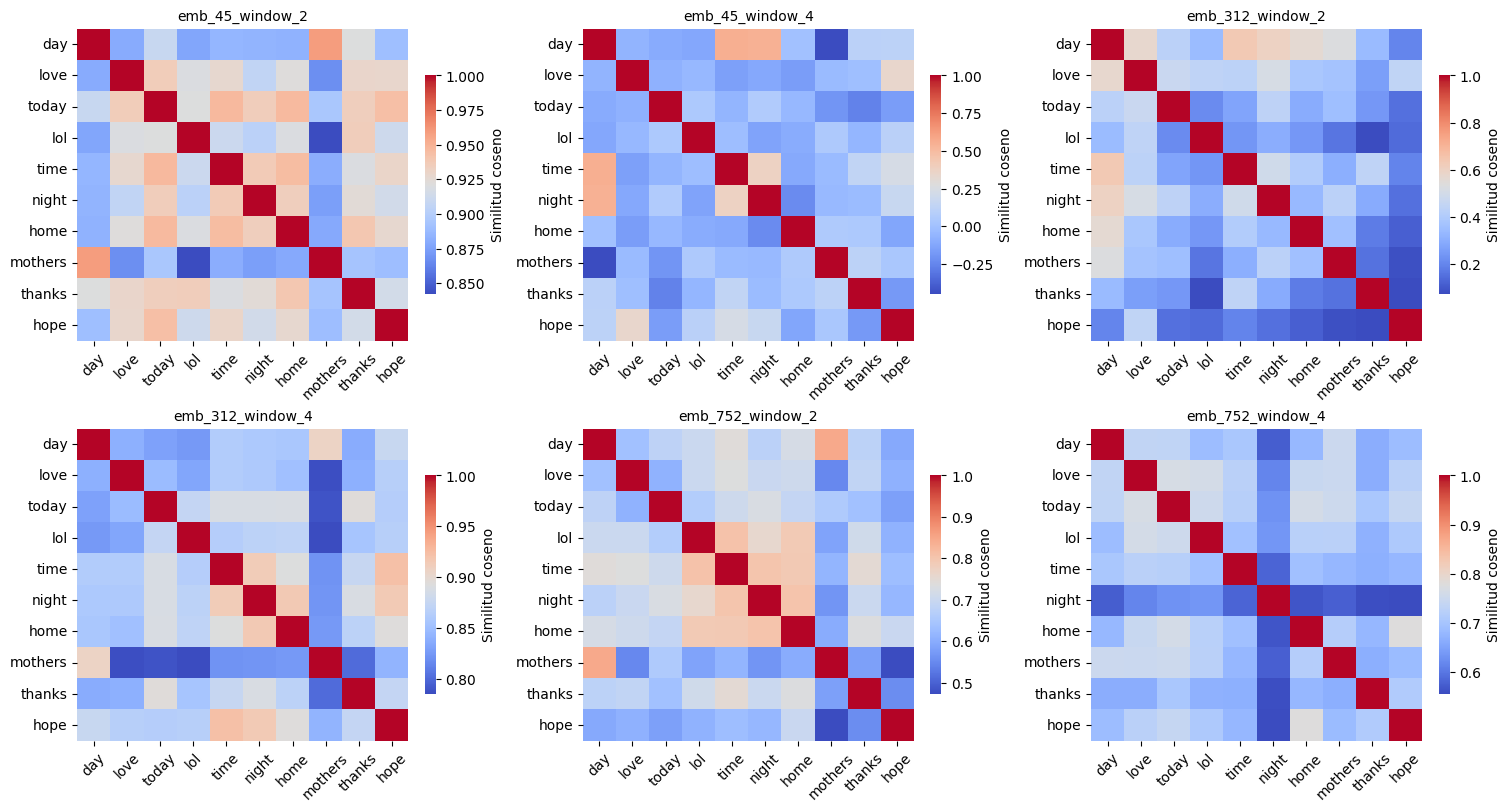

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# 1) Lista de las 10 palabras puras (sin frecuencia)
top_10_words = [w for w, _ in top_10]

# 2) Extrae los índices solo de las que estén en el vocabulario
indices = []
words = []
for w in top_10_words:
    if w in word2idx:
        indices.append(word2idx[w])
        words.append(w)
    else:
        print(f"Advertencia: '{w}' no está en el vocabulario")

# 3) Cantidad de modelos a graficar
n_models = len(final_embeddings)
cols = 3
rows = (n_models + cols - 1) // cols

# 4) Crear figura con constrained_layout
fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)
axs = axs.flatten()

# 5) Recorremos los embeddings
for i, (model_key, emb_matrix) in enumerate(final_embeddings.items()):
    submat = emb_matrix[indices]
    sim_mat = cosine_similarity(submat)
    df_sim = pd.DataFrame(sim_mat, index=words, columns=words)

    sns.heatmap(
        df_sim,
        ax=axs[i],
        cmap="coolwarm",
        annot=False,
        cbar=True,
        cbar_kws={'shrink': 0.7, 'label': 'Similitud coseno'}
    )
    axs[i].set_title(model_key, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].tick_params(axis='y', rotation=0)

# 6) Eliminar ejes vacíos
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.show()


In [21]:


# Define aquí tres grupos basados en tu top-10
grupos = {
    'Día/Mañana':     ['day', 'today', 'morning'],
    'Emoción Positiva':['love', 'hope', 'thanks'],
    'Risa/Conversación':['lol', 'thanks', 'mothers']  # ejemplo mixto
}

for model_key, emb_matrix in final_embeddings.items():
    print(f"\n=== Similitudes para {model_key} ===")
    # Extrae solo los vectores de tus 10 palabras
    submat = emb_matrix[indices]           # (10, emb_dim)
    sim_mat = cosine_similarity(submat)    # (10, 10)

    # Mapea palabra -> posición en 'words'
    pos = {w:i for i,w in enumerate(words)}

    for nombre, group in grupos.items():
        # Filtra solo los que realmente están en tu top
        valid = [w for w in group if w in pos]
        idxs  = [pos[w] for w in valid]
        if len(idxs) < 2:
            print(f"  * Grupo «{nombre}» tiene <2 palabras válidas, omito.")
            continue

        sims = []
        print(f"\n  Grupo «{nombre}»: {valid}")
        for i,j in combinations(idxs, 2):
            s = sim_mat[i, j]
            sims.append(s)
            print(f"    Sim({words[i]}, {words[j]}) = {s:.3f}")

        print(f"    → Similitud media = {np.mean(sims):.3f}")




=== Similitudes para emb_45_window_2 ===

  Grupo «Día/Mañana»: ['day', 'today']
    Sim(day, today) = 0.909
    → Similitud media = 0.909

  Grupo «Emoción Positiva»: ['love', 'hope', 'thanks']
    Sim(love, hope) = 0.928
    Sim(love, thanks) = 0.929
    Sim(hope, thanks) = 0.914
    → Similitud media = 0.924

  Grupo «Risa/Conversación»: ['lol', 'thanks', 'mothers']
    Sim(lol, thanks) = 0.935
    Sim(lol, mothers) = 0.842
    Sim(thanks, mothers) = 0.893
    → Similitud media = 0.890

=== Similitudes para emb_45_window_4 ===

  Grupo «Día/Mañana»: ['day', 'today']
    Sim(day, today) = -0.106
    → Similitud media = -0.106

  Grupo «Emoción Positiva»: ['love', 'hope', 'thanks']
    Sim(love, hope) = 0.342
    Sim(love, thanks) = -0.009
    Sim(hope, thanks) = -0.180
    → Similitud media = 0.051

  Grupo «Risa/Conversación»: ['lol', 'thanks', 'mothers']
    Sim(lol, thanks) = -0.053
    Sim(lol, mothers) = 0.049
    Sim(thanks, mothers) = 0.117
    → Similitud media = 0.038

=== 

# **FASE 3**

In [22]:
# 1) Carga y limpieza
train_df['text_clean'] = train_df['text'].apply(limpiar_texto)
test_df ['text_clean'] = test_df ['text'].apply(limpiar_texto)

In [78]:
# --- FASE 3: DOS RNN SECUENCIALES CON EMBEDDINGS PRE-ENTRENADOS ---

# Parámetros generales
maxlen        = 30
batch_rnn     = 128
epochs_rnn    = 5
learning_rate = 0.004

# 1) Usa SMALL_TRAIN_DF / SMALL_TEST_DF y quita filas sin etiqueta
train_df.dropna(subset=['sentiment'], inplace=True)
test_df.dropna(subset=['sentiment'], inplace=True)

texts_train = train_df['text_clean'].tolist()
texts_test  = test_df['text_clean'].tolist()

# 2) LabelEncoder para convertir strings → enteros
le       = LabelEncoder()
y_train  = le.fit_transform(train_df['sentiment'])
y_test   = le.transform(test_df['sentiment'])
y_train  = y_train.astype('int32')
y_test   = y_test.astype('int32')
num_classes = len(le.classes_)
print("Clases sentiment codificadas:", le.classes_)

# 3) Secuencias + padding
seq_train = tokenizer.texts_to_sequences(texts_train)
seq_test  = tokenizer.texts_to_sequences(texts_test)
X_train   = pad_sequences(seq_train, maxlen=maxlen, padding='post')
X_test    = pad_sequences(seq_test,  maxlen=maxlen, padding='post')

# 4) Crea datasets optimizados
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
                         .shuffle(len(X_train)) \
                         .batch(batch_rnn) \
                         .prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
                         .batch(batch_rnn) \
                         .prefetch(tf.data.AUTOTUNE)

# 5) Elige qué embeddings usar
key_A = 'emb_45_window_2'
key_B = 'emb_45_window_4'
emb_A = final_embeddings[key_A]
emb_B = final_embeddings[key_B]



Clases sentiment codificadas: ['negative' 'neutral' 'positive']


In [79]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

# --- Modelo A con regularización y dropout ---
model_A = keras.Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=emb_A.shape[1],
              weights=[emb_A],
              trainable=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(GRU(64)),
    Dropout(0.4),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name='Model_A')

model_A.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)
model_A.summary()
# --- Modelo B con regularización y dropout ---
model_B = keras.Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=emb_B.shape[1],
              weights=[emb_B],
              trainable=True),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name='Model_B')

model_B.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)
model_B.summary()

Model: "Model_A"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ ?                      │       135,045 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_30                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_31                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,045 (527.52 KB)

 Trainable params: 135,045 (527.52 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Model_B"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ ?                      │       135,045 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_32                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,045 (527.52 KB)

 Trainable params: 135,045 (527.52 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # monitor validation loss
    factor=0.5,             # reduce by half
    patience=1,             # after 1 epoch with no improvement
    min_lr=1e-5,            # don't go below this
    verbose=1
)

In [81]:
## nota: PARA EJECUTAR DE NUEVO, ANTES EJECUTAR LA DEFINICIÓN DE LOS MODELOS PARA QUE EMPIECEN DE CERO
# 8) Entrena ambos
print("\n>>> Entrenando Model A")
history_A = model_A.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs_rnn,
    class_weight=class_weights,
    callbacks=[reduce_lr]
)

print("\n>>> Entrenando Model B")
history_B = model_B.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs_rnn,
    class_weight=class_weights,
    callbacks=[reduce_lr]
)




>>> Entrenando Model A
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3926 - loss: 1.0732 - val_accuracy: 0.6873 - val_loss: 0.7247 - learning_rate: 0.0040
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7022 - loss: 0.6918 - val_accuracy: 0.7102 - val_loss: 0.6805 - learning_rate: 0.0040
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7488 - loss: 0.6137 - val_accuracy: 0.7227 - val_loss: 0.6518 - learning_rate: 0.0040
Epoch 4/5
213/215 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7706 - loss: 0.5646
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0020000000949949026.
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7704 - loss: 0.5649 - val_accuracy: 0.7029 - val_loss: 0.6679 - learning_rate: 0.0040
Epoch 5/5
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7835 - loss: 0.5326
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 

## MODELO A

In [82]:
import numpy as np

# Get predicted class probabilities
y_probs = model_A.predict(X_train)

# Get predicted class labels (highest probability)
y_pred = np.argmax(y_probs, axis=1)


859/859 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


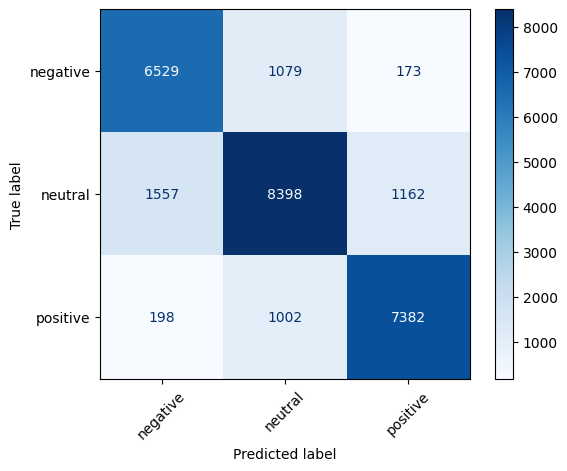

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)


## MODELO B

In [84]:
import numpy as np

# Get predicted class probabilities
y_probs = model_B.predict(X_train)

# Get predicted class labels (highest probability)
y_pred = np.argmax(y_probs, axis=1)

859/859 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


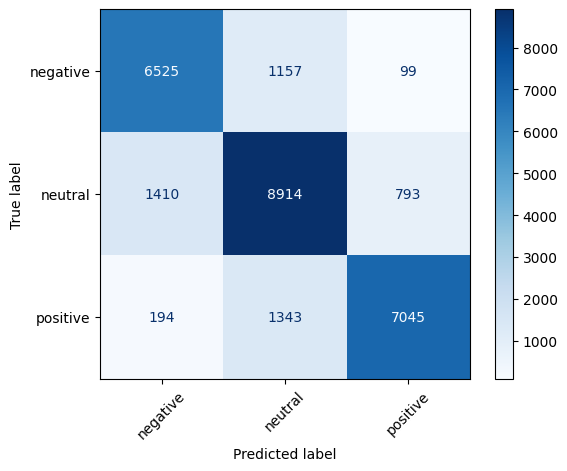

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)


=== Evaluación en TEST ===

--- Model A ---
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.77      0.73      1001
     neutral       0.70      0.65      0.67      1430
    positive       0.78      0.78      0.78      1103

    accuracy                           0.72      3534
   macro avg       0.73      0.73      0.73      3534
weighted avg       0.72      0.72      0.72      3534


--- Model B ---
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.77      0.73      1001
     neutral       0.69      0.68      0.69      1430
    positive       0.81      0.75      0.77      1103

    accuracy                           0.73      3534
   macro avg       0.73      0.73      0.73      3534
weighted avg       0.73      0.73      0.73      3534



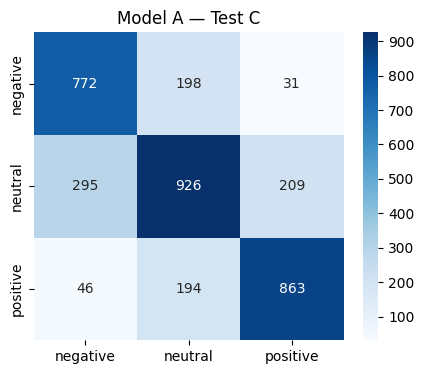

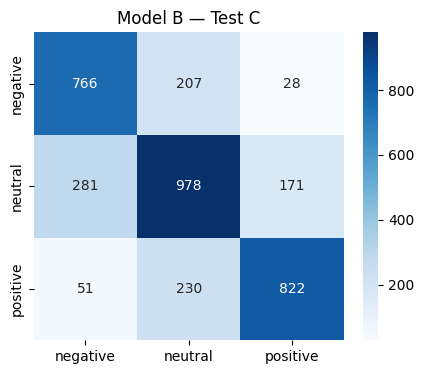

In [86]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\n=== Evaluación en TEST ===")
for name, model in [('Model A', model_A), ('Model B', model_B)]:
    print(f"\n--- {name} ---")

    # Predicción en test
    y_test_probs = model.predict(X_test)
    y_test_pred = np.argmax(y_test_probs, axis=1)

    # Matriz de confusión
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Métricas detalladas
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

    # Gráfico
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{name} — Test C')


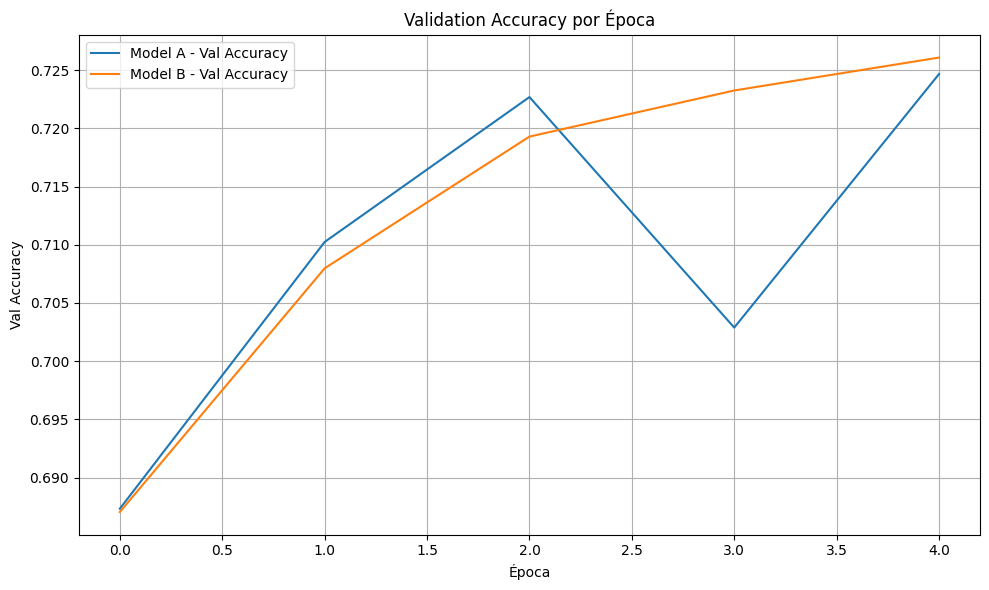

In [88]:
import matplotlib.pyplot as plt

# Extraer val_accuracy de cada modelo
val_acc_A = history_A.history['val_accuracy']
val_acc_B = history_B.history['val_accuracy']

# Crear la figura
plt.figure(figsize=(10, 6))
plt.plot(val_acc_A, label='Model A - Val Accuracy')
plt.plot(val_acc_B, label='Model B - Val Accuracy')
plt.title('Validation Accuracy por Época')
plt.xlabel('Época')
plt.ylabel('Val Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [89]:
# List of sample indices to test
sample_indices = [0,1,2]

# Loop through each sample
for idx in sample_indices:
    # 1) Saca una frase de prueba
    sample_text = test_df['text_clean'].iloc[idx]
    print(f"\n-----\nSample text: {sample_text}")

    # 2) Tokeniza y paddea la frase
    sample_seq = tokenizer.texts_to_sequences([sample_text])
    sample_pad = pad_sequences(sample_seq, maxlen=maxlen, padding='post')

    # 3) MODELO A
    print("=================Utilizando el modelo A=================")
    model = model_A  # o model_B

    # 4) Predicción
    pred_probs = model.predict(sample_pad)
    pred_label = np.argmax(pred_probs, axis=1)[0]
    pred_class = le.inverse_transform([pred_label])[0]

    # Imprimir el resultado con las probabilidades de cada clase
    print(f"\nPredicted sentiment: {pred_class} with")

    # Especificar las probabilidades para cada clase (asumimos que hay 3 clases: negative, neutral, positive)
    labels = ['negative', 'neutral', 'positive']
    for i, prob in enumerate(pred_probs[0]):
        print(f"Probability of {labels[i]}: {prob:.8f}")

    # MODELO B
    print("=================Utilizando el modelo B=================")
    model = model_B

    # 4) Predicción
    pred_probs = model.predict(sample_pad)
    pred_label = np.argmax(pred_probs, axis=1)[0]
    pred_class = le.inverse_transform([pred_label])[0]

    # Imprimir el resultado con las probabilidades de cada clase
    print(f"\nPredicted sentiment: {pred_class} with")

    # Especificar las probabilidades para cada clase (asumimos que hay 3 clases: negative, neutral, positive)
    labels = ['negative', 'neutral', 'positive']
    for i, prob in enumerate(pred_probs[0]):
        print(f"Probability of {labels[i]}: {prob:.8f}")



-----
Sample text: last session of the day  httptwitpiccom67ezh
=================Utilizando el modelo A=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

Predicted sentiment: neutral with
Probability of negative: 0.11122920
Probability of neutral: 0.59880030
Probability of positive: 0.28997046
=================Utilizando el modelo B=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step

Predicted sentiment: neutral with
Probability of negative: 0.07586349
Probability of neutral: 0.89888567
Probability of positive: 0.02525072

-----
Sample text:  shanghai is also really exciting precisely  skyscrapers galore good tweeps in china  sh  bj
=================Utilizando el modelo A=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Predicted sentiment: positive with
Probability of negative: 0.00084352
Probability of neutral: 0.01940995
Probability of positive: 0.97974646
=================Utilizando el modelo B=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

Predicted se